In [1]:
## pip install --user itkwidgets
## pip install --uesr tensorboard-plugin-3d
import os
import glob
import shutil
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from monai.utils import first, set_determinism
from monai.data import DataLoader, Dataset
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image

from itkwidgets import view
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    CropForegroundd,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.config import print_config

In [4]:
print_config()

MONAI version: 1.2.dev2302
Numpy version: 1.19.2
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 708e1a1cf4a1d5516eaf65b8a0bee8887cdee494
MONAI __file__: c:\users\user\appdata\local\programs\python\python38\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.11.2
gdown version: 4.6.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-depe

In [5]:
os.listdir("data/")

['images', 'manual_spleen_segmentations']

In [6]:
train_images= sorted(glob.glob("data/images/*.nii"))
train_labels= sorted(glob.glob("data/manual_spleen_segmentations/*.nii"))

In [7]:
data_dicts= [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)]

In [8]:
data_dicts[0]

{'image': 'data/images\\00001---002.nii',
 'label': 'data/manual_spleen_segmentations\\00001---002.nii'}

In [9]:
data_dicts_orig= data_dicts

In [10]:
set_determinism(seed= 777)

In [11]:
both_keys= ["image", "label"]
pixdim= (1.5, 1.5, 2.0)

"""
level: 80
width= 120,150, 100
====================
level: 90
width= 80, 90, 100, 110, 120
"""
level= 90
width= 90
a_min= level - (width//2)
a_max= level + (width//2)

print(f" a_min: {a_min}, a_max:{a_max}")

 a_min: 45, a_max:135


______

In [12]:
transform_orig= Compose([
    LoadImaged(both_keys),
    EnsureChannelFirstd(keys=both_keys),
#     Orientationd(keys=both_keys, axcodes="PLS"),
#     Spacingd(keys=both_keys, pixdim= pixdim, mode= ("bilinear", "nearest")),
#     ScaleIntensityRanged(keys=['image'], a_min=a_min, a_max=a_max, b_min= 0.0, b_max= 1.0, clip= True),
#     CropForegroundd(keys= both_keys, source_key= "image"),
])

In [13]:
check_ds_orig= Dataset(data= data_dicts_orig, transform= transform_orig)
check_loader_orig= DataLoader(check_ds_orig, batch_size= 1)
data_orig= first(check_loader_orig)
print(f"orig image shape: {data_orig['image'].shape} \norig mask shape: {data_orig['label'].shape}")
## 1, 1, 512, 512, 116 ===> batch, channel_first, width, height, channels

orig image shape: torch.Size([1, 1, 512, 512, 116]) 
orig mask shape: torch.Size([1, 1, 512, 512, 116])


_____

In [14]:
transform= Compose([
    LoadImaged(both_keys),
    EnsureChannelFirstd(keys=both_keys),
    Orientationd(keys=both_keys, axcodes="PLS"),
    Spacingd(keys=both_keys, pixdim= pixdim, mode= ("bilinear", "nearest")),
    ScaleIntensityRanged(keys=['image'], a_min=a_min, a_max=a_max, b_min= 0.0, b_max= 1.0, clip= True),
    CropForegroundd(keys= both_keys, source_key= "image"),
])

In [15]:
check_ds= Dataset(data= data_dicts, transform= transform)
check_loader= DataLoader(check_ds, batch_size= 1)
data= first(check_loader)
print(f"image shape: {data['image'].shape} \nmask shape: {data['label'].shape}")

image shape: torch.Size([1, 1, 167, 219, 231]) 
mask shape: torch.Size([1, 1, 167, 219, 231])


## Visualize the image with MONAI `matshow3d` API

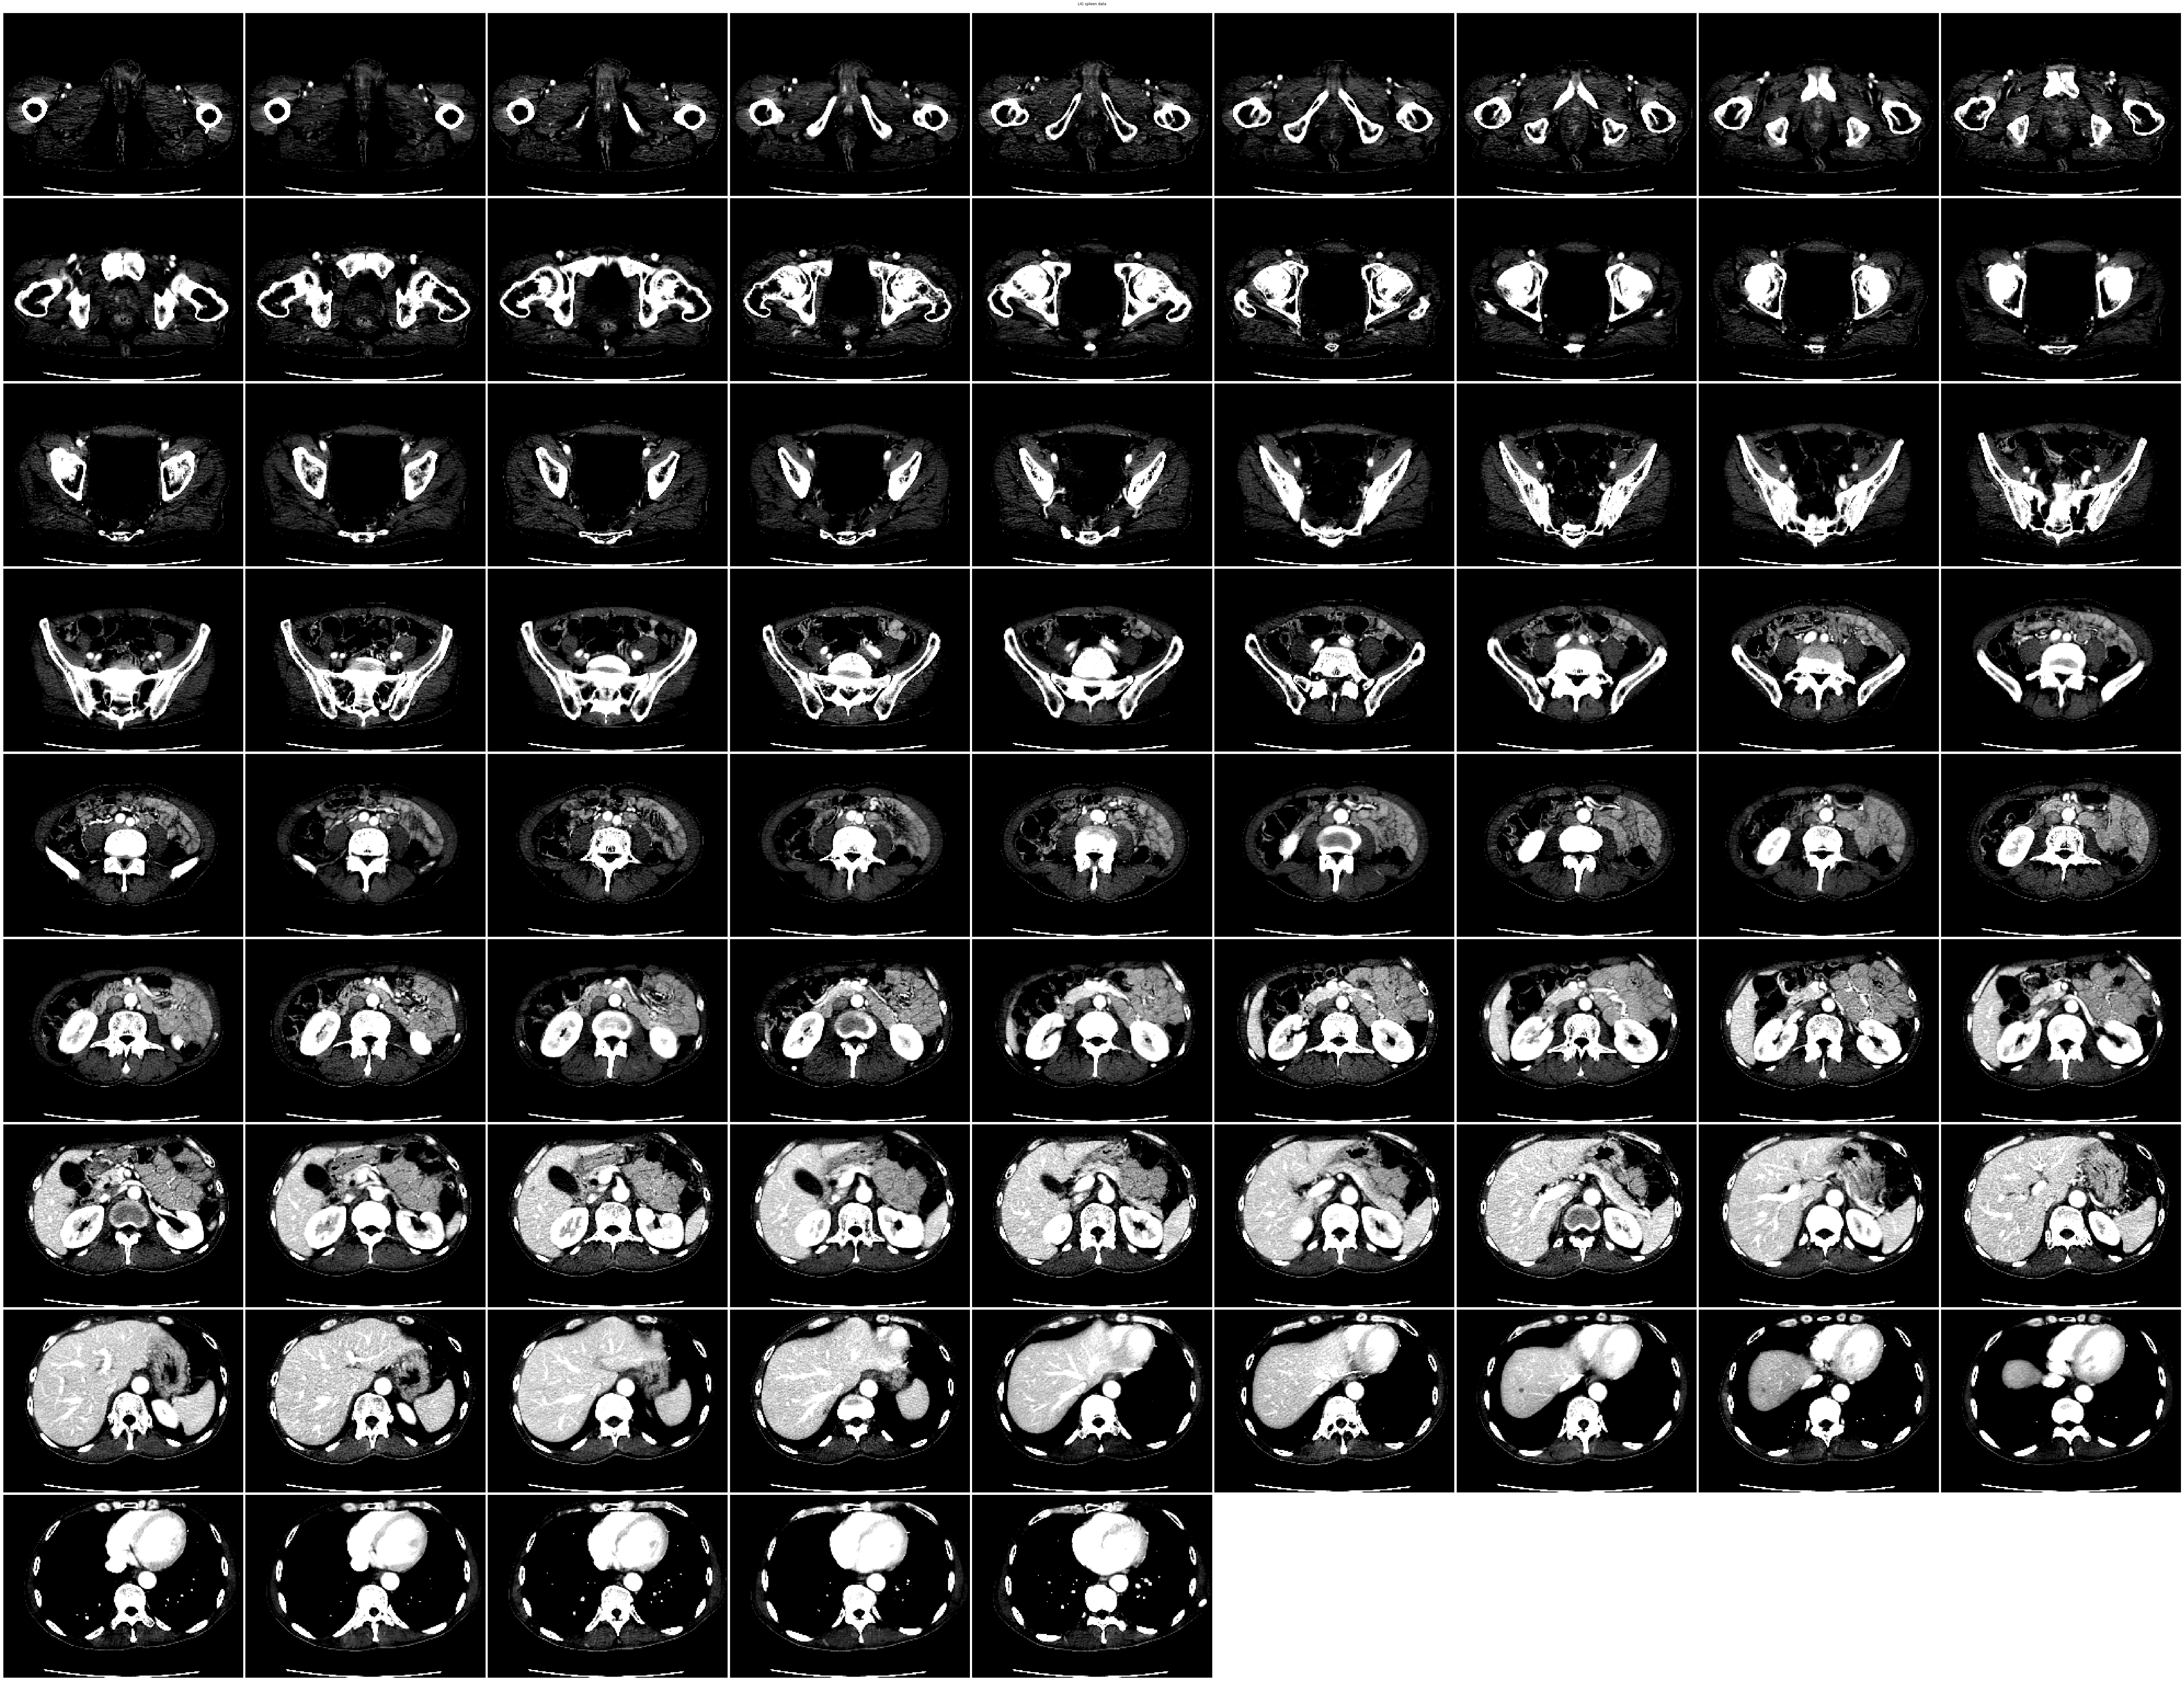

(<Figure size 7200x7200 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan,  0.,  0., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

In [16]:
matshow3d(
    volume= data['image'],
    fig= None, title= 'LIG spleen data',
    figsize=(100, 100),
    every_n=3,
    frame_dim= -1,
    show= True,
    cmap= 'gray',
)

_____
## Blend the image and label to check the segmentation region
It expects `channel-first` data shape, and users can specify colormap in the matplotlib, default to `hsv`.

In [43]:
ret = blend_images(image=data["image"][0], label=data["label"][0], alpha=0.5, cmap="hsv", rescale_arrays=False)
print(ret.shape)

torch.Size([3, 167, 219, 231])


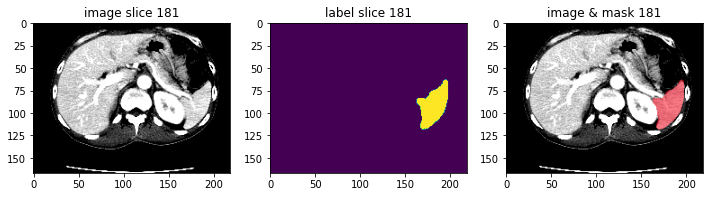

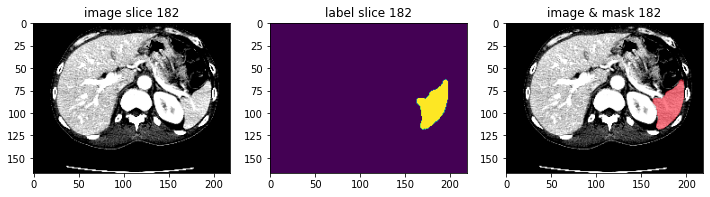

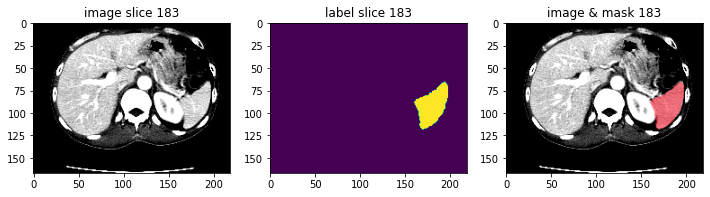

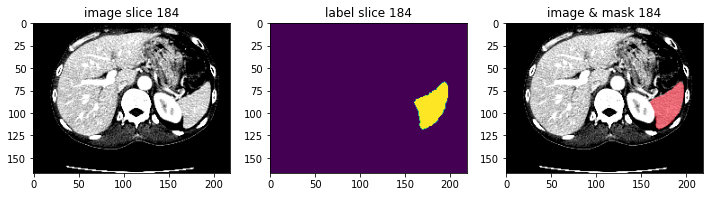

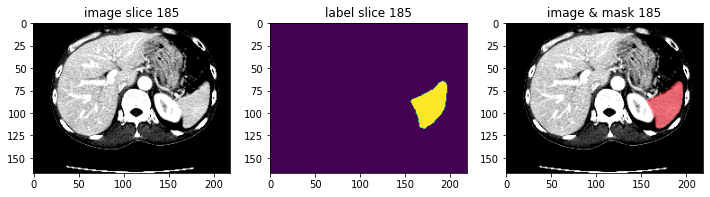

In [45]:
for i in range(1, 6):
    # plot the slice 50 - 100 of image, label and blend result
    slice_index = 180 + i
    plt.figure("blend image and label", (12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(data["image"][0, 0, :, :, slice_index], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label slice {slice_index}")
    plt.imshow(data["label"][0, 0, :, :, slice_index])
    plt.subplot(1, 3, 3)
    plt.title(f"image & mask {slice_index}")
    # switch the channel dim to the last dim
    plt.imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))
    plt.show()

## Leverage `itkwidgets` to interactively visualize `image` and `label`

`itkwidgets` expects image and label with no batch or channel dim, and we set `gradient_opacity=0.4` so that no slider adjustments need to be made. For more details, please check: https://github.com/InsightSoftwareConsortium/itkwidgets.

In [26]:
view(image=data["image"][0, 0, :, :, :] * 255, label_image=data["label"][0, 0, :, :, :] * 255, gradient_opacity=0.4)

Viewer(geometries=[], gradient_opacity=0.4, interpolation=False, point_sets=[], rendered_image=<itk.itkImagePy…

## Visualize the 3D image in TensorBoard as GIF images

In [22]:
# os.mkdir("tensorboard")
tesnor_dir="tensorboard/"

In [23]:
plot_2d_or_3d_image(data=data['image'],step= 0, writer= SummaryWriter(log_dir= tesnor_dir), frame_dim= -1)

In [24]:
%load_ext tensorboard
%tensorboard --logdir=$"tensorboard"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorboard\compat\__init__.py", line 42, in tf
    from tensorboard.compat import notf  # noqa: F401
ImportError: cannot import name 'notf' from 'tensorboard.compat' (C:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorboard\compat\__init__.py)

During handling of the above exception, another exception occurred:

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd
TensorFlow installation not found - running with reduced feature set.
RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd
ImportError: numpy.core.multiarray failed to import

The above exception was the direct cause of the following exception:

SystemError: <built-in method __contains__ of dict object at 0x00000214A9FB1F00> returned a result with a